### Generate the tuning hyperparameters
In order to fairly evaluate the algorithms, the hyperparameters need to be tuned.
I use random tuning.
This script outputs a text file for hyperparameters.
Each line of the text file can be passed as a command line argument to `run_experiment.py`

In [401]:
# imports
import numpy as np
import pandas as pd
import random
import os
import re
import ast
import pickle
import matplotlib.pyplot as plt

In [212]:
# define hyperparameters and sampling ranges
random.seed(42)

# things to hit
_agent=["DQN","UADQN"]
_action_selection=["softmax", "egreedy"]
_seed = [1]
_n_episodes = [100]

# things to sample from
_lr = [1e-1, 7e-2, 3e-2, 1e-2, 7e-3, 3e-3, 1e-3, 7e-4, 3e-4, 1e-4, 7e-5, 3e-5, 1e-5]
_batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256]
_adam_epsilon = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
_update_target = [4, 8, 16, 32]
_epsilon_final = [0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01]

# generate samples
result = ""
#DQN
for action_selection in _action_selection:
    for n_episodes in _n_episodes:
        for _ in range(200):
            for seed in _seed:
                line = '--agent=DQN '
                line += '--action_selection='+action_selection+ ' '
                line += '--n_episodes='+str(n_episodes) + " "

                line += '--lr='+str(random.sample(_lr,1)[0]) + " "
                line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
                line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
                line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "
                if action_selection=="egreedy":
                    line += '--epsilon_final='+str(random.sample(_epsilon_final,1)[0]) + " "


                result += line + '--seed='+str(seed) + "\n"
# UADQN
for n_episodes in _n_episodes:
    for _ in range(100):
        for seed in _seed:
            line = '--agent=UADQN '
            line += '--n_episodes='+str(50) + " "

            line += '--lr='+str(random.sample(_lr,1)[0]) + " "
            line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
            line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
            line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "


            result += line + '--seed='+str(seed) + "\n"

# write text file

with open("tuning.txt", "w") as f:
    f.write(result)

### Evaluate Tuning Results
After the tuning runs, the results are stored in the `results` folder.
I read them in and generate files `tuned_hyperparameters_DQN_softmax.txt`, `tuned_hyperparameters_DQN_egreedy.txt`, `tuned_hyperparameters_UADQN.txt` with the optimal hyperparameter values for the three algorithms.

In [418]:
tuning_results="results/"
# read results
run_folders = [tuning_results+s for s in os.listdir(tuning_results) if s.startswith("2022")]
run_folders.sort(key=lambda f: int(re.findall(r"[\d]+\Z", f)[0]))

params = []
episode_scores = []
for run_folder in run_folders:
    with open(run_folder+"/experimental-setup", "r") as setup:
        setup_dict = ast.literal_eval(setup.read())
        setup_dict["agent"] = "UADQN" if re.search(r"UADQN", run_folder) else "DQN"
        params.append(setup_dict)
    try:
        with open(run_folder+"/log_data.pkl", "rb") as scores:
            episode_scores.append([score for score, ts in pickle.load(scores)["Episode_score"]])
    except (FileNotFoundError):
        episode_scores.append("")

In [419]:
# generate dataframes:
setups = pd.DataFrame(params)
scores = pd.DataFrame(episode_scores)
#plt.plot(scores, alpha = 0.1, color="blue")
#setups


In [420]:
setups["final_score"] = scores[99]
setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]


#dqn-softmax
dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
dqn_softmax_best_i = setups["final_score"][dqn_softmax_is].idxmax()


#dqn-egreedy
dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index
dqn_egreedy_best_i = setups["final_score"][dqn_egreedy_is].idxmax()


#uadqn
uadqn_is = setups[setups["agent"] == "UADQN"].index
uadqn_best_i = setups["final_score"][uadqn_is].idxmax()



/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index


In [421]:

print("Best UADQN:", uadqn_best_i, setups["final_score"][uadqn_best_i])
print("Best Softmax DQN:", setups["final_score"][dqn_softmax_best_i])
print("Best egreedy DQN:", setups["final_score"][dqn_egreedy_best_i])

setups[setups.index == dqn_softmax_best_i]["minibatch_size"]

Best UADQN: 448 -583.7762383299705
Best Softmax DQN: -841.245053326973
Best egreedy DQN: -1076.2432608886447


117    128
Name: minibatch_size, dtype: int64

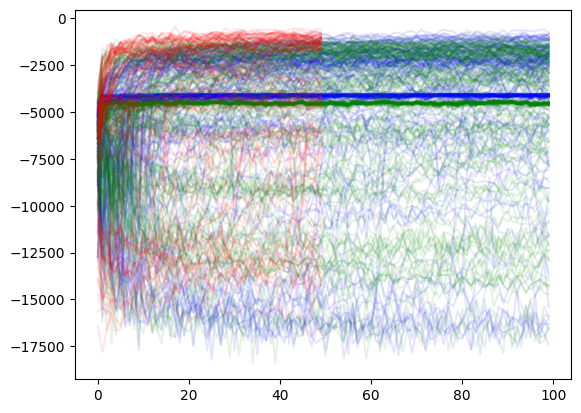

In [378]:
plt.plot(scores.transpose()[dqn_softmax_is], alpha = 0.1, color="blue")
plt.plot(scores.transpose()[dqn_egreedy_is], alpha = 0.1, color="green")
plt.plot(scores.transpose()[uadqn_is], color="red", alpha=0.1)

### Generate Tuning Plots
From the tuning results, some things can be visualized:

For every algorithm:
1. the effect of individual hyperparameters on performance
2. ...
3. ...

In [396]:
setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].groupby(["minibatch_size",]).mean()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("minibatch_size").mean()["final_score"]
#setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby(["update_target_frequency", "minibatch_size"]).describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").mean()["final_score"]

/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/3240964722.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].groupby(["minibatch_size",]).mean()["final_score"]


minibatch_size
1     -4226.298811
2     -3930.229421
4     -3679.592470
8     -5505.641316
16    -5146.633094
32    -6038.256071
64    -6258.051877
128   -5238.466587
256   -7132.336767
Name: final_score, dtype: float64

### Validate Tuning results
For every algorithm, I choose the best performing run and validate its stability by running them with 10 different seeds.
For this, I generate new confic files `tuning_validation.txt` and `tuning_validation.sbatch`



In [390]:
# generate samples
result = ""

#DQN-softmax
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[dqn_softmax_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--action_selection='+run["action_selection"]+ ' '
    line += '--n_episodes=100 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    result += line + '--seed='+str(seed) + "\n"


# DQN-egreedy
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[dqn_egreedy_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--action_selection='+run["action_selection"]+ ' '
    line += '--n_episodes=100 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    if run["action_selection"]=="egreedy":
        line += '--epsilon_final='+str(run["final_exploration_rate"]) + " "
    result += line + '--seed='+str(seed) + "\n"

# UADQN
for seed in [1,2,3,4,5,6,7,8,9,10]:
    run = setups.loc[uadqn_best_i,]
    line = '--agent=' + run["agent"] + ' '
    line += '--n_episodes=50 '
    line += '--lr='+str(run["learning_rate"]) + " "
    line += '--batch_size='+str(run["minibatch_size"]) + " "
    line += '--adam_epsilon='+str(run["adam_epsilon"]) + " "
    line += '--update_target='+str(run["update_target_frequency"]) + " "
    result += line + '--seed='+str(seed) + "\n"

# write text file

with open("tuning_validation.txt", "w") as f:
    f.write(result)

In [424]:
# read results of validation runs:
validation_results="../../results/"
# read results
run_folders = [validation_results+s for s in os.listdir(validation_results) if s.startswith("2022")]
run_folders.sort(key=lambda f: int(re.findall(r"[\d]+\Z", f)[0]))

params = []
episode_scores = []
for run_folder in run_folders:
    with open(run_folder+"/experimental-setup", "r") as setup:
        setup_dict = ast.literal_eval(setup.read())
        setup_dict["agent"] = "UADQN" if re.search(r"UADQN", run_folder) else "DQN"
        params.append(setup_dict)
    try:
        with open(run_folder+"/log_data.pkl", "rb") as scores:
            episode_scores.append([score for score, ts in pickle.load(scores)["Episode_score"]])
    except (FileNotFoundError):
        episode_scores.append("")


    # generate dataframes:
setups = pd.DataFrame(params)
scores = pd.DataFrame(episode_scores)

setups["final_score"] = scores[99]
setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]

/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/1846742921.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]


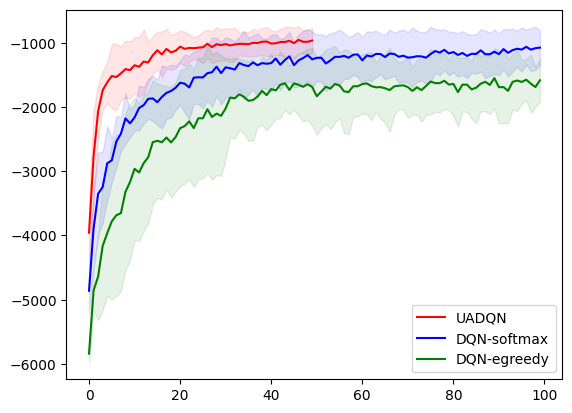

In [446]:
# generate validation plot
uadqn_scores = scores[(setups["agent"] == "UADQN")]
plt.plot(uadqn_scores.mean().transpose(), alpha = 1, color="red", label="UADQN")
plt.fill_between(x=uadqn_scores.transpose().index,
                 y1=uadqn_scores.mean().transpose() - uadqn_scores.std().transpose(),
                 y2=uadqn_scores.mean().transpose() + uadqn_scores.std().transpose(), 
                 alpha = 0.1, color="red")

dqn_softmax_scores = scores[(setups["agent"] == "DQN") & (setups["action_selection"] == "softmax")]
plt.plot(dqn_softmax_scores.mean().transpose(), alpha = 1, color="blue", label="DQN-softmax")
plt.fill_between(x=dqn_softmax_scores.transpose().index,
                 y1=dqn_softmax_scores.mean().transpose() - dqn_softmax_scores.std().transpose(),
                 y2=dqn_softmax_scores.mean().transpose() + dqn_softmax_scores.std().transpose(), 
                 alpha = 0.1, color="blue")

dqn_egreedy_scores = scores[(setups["agent"] == "DQN") & (setups["action_selection"] == "egreedy")]
plt.plot(dqn_egreedy_scores.mean().transpose(), alpha = 1, color="green", label="DQN-egreedy")
plt.fill_between(x=dqn_egreedy_scores.transpose().index,
                 y1=dqn_egreedy_scores.mean().transpose() - dqn_egreedy_scores.std().transpose(),
                 y2=dqn_egreedy_scores.mean().transpose() + dqn_egreedy_scores.std().transpose(), 
                 alpha = 0.1, color="green")



plt.legend()


plt.savefig("tuning_validation.png")

-583.7762383299705